# Ad Navigator: A tool to optimize online marketing investments 
## Insight data science project

In this notebook I am going to describe how I analyzed online advertisement data collected from Facebook ads in a consulting project for a startup company. I can't share their data, but I hope that the code itself and the thought process behind it will be helpful. 

In this notebook, I will show some exploratory data analysis, as well as in depth analysis of important metrics and their impact for 28 days after the initial investment. In the next notebook, I show further exploratory data analysis, as well as a case study for predicting success of a future marketing campaign using supervised machine learning.

I developed a web app using Flask that has this code in the back end (with slight modifications where some of the variables are user input).

In [29]:
import pandas as pd
from pandas import ExcelWriter, ExcelFile
from pandas.tools.plotting import table
from datetime import datetime, date, timedelta 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors



The dataset was initially contained in a large excel file with many sheets. After some cleaning, I created separate CSV files, each one with a specific date on it. This date is the day in which all the data were updated, however each file contains also the date in which the ad was first launched ("reporting starts"). The end goal is to iterate through this dataset and create visualizations from day 1 to day 28 of important metrics, such as amount spent, link clicks and purchases.

In [6]:
#Here I am creaing a list of dates which will allow me to iterate through the dataset

sample_list1 = ['2017-{0:02d}-{1:02d}'.format(mon, day) for mon in range(10,13) for day in range(1, 32)] 
sample_list2 = ['2018-{0:02d}-{1:02d}'.format(mon, day) for mon in range(1,2) for day in range(1, 11)] 
sample_list1.remove('2017-11-31')
sample_list1.remove('2017-10-21')

del sample_list1[0:20]
dates0= sample_list1+sample_list2
dates = dates0[0:len(dates0)-2]



In [7]:
#Creating a dictionary of dates, each item containing a table/dataframe
#Converting the index to a date time object

savedict = {}
for date in dates:
    savedict[date] = pd.read_csv('data_clean_csv_files/'+date+'.csv')
    dfc = savedict[date]
    dfc["Reporting Starts"]=pd.to_datetime(dfc["Reporting Starts"])
    dfc.index = dfc["Reporting Starts"]
    dfc.drop(columns=["Reporting Starts"])
    del dfc

In [8]:
#Let's pick one date and show the first rows
#These are cleaned up data and therefore need no further cleaning (I had to do some cleaning of strings, fill NaN,
#and eliminate unnecessary columns)
ex=savedict['2017-11-15']
ex.head()

,Reporting Starts,CPC (Cost per Link Click) (USD),Impressions,Link Clicks,Amount Spent (USD),Ad Set Name,Ad Name,Campaign Name,CTR (Link Click-Through Rate),Website Adds to Cart,Website Purchases
Reporting Starts,,,,,,,,,,,
2017-10-21,2017-10-21,5.280,153.0,1.0,5.28,STG2_30DayVisitor_Combined,VNT_ChickenChew_00,STAGE02 - VALIDATION,0.653595,0.0,0.0
2017-10-21,2017-10-21,0.581,418.0,10.0,5.81,STG1_0%2%LAL_Best_Customers - Combined,EXP_Modular_00_LP_Assembly,STAGE01 - EDUCATION,2.392344,2.0,1.0
2017-10-21,2017-10-21,0.000,56.0,0.0,0.65,STG1_0%2%LAL_Best_Customers - Combined,EXP_LifeProof_00,STAGE01 - EDUCATION,0.000000,0.0,0.0
2017-10-21,2017-10-21,0.000,54.0,0.0,0.88,STG1_Faraday_500k_LAL_Lead_Conversion,EXP_MadeForPlay_00,STAGE01 - EDUCATION,0.000000,0.0,0.0
2017-10-21,2017-10-21,0.000,18.0,0.0,0.24,STG1_Faraday_500k_LAL_Lead_Conversion,UTC_MakingMovingSuckLess_00,STAGE01 - EDUCATION,0.000000,0.0,0.0


The data is organized in campaign stages. At the top of the marketing funnel there is "Awareness", and going down
there's "Education", "Validation" and "Conversion". These campaign stages all have somewhat different purposes.
Awareness is about making the clients aware of this new product. Education provides clients with additional characteristics of the product (such as where it was built, material etc.) Validation wants clients to click on the ads and make them browse the website, possibly adding items to cart. Conversion wants clients to purchase.

Because of the substantially differently purposes of the campaigns the data needs to be sorted by campaign name. However, once the campaign name to analyze is chosen, the user has the option of looking at it globally or further narrowing it down by Ad Set name (contains targeting information such as age range, location, etc.) or the specific ad name (each characterized by a unique combination of images, videos and text).


In [10]:
#Making a copy of the dictionary and showing all the possible campaign stage names options
saved = savedict.copy()

ex = saved['2017-11-15']
print("Choose Campaign Name: ",ex['Campaign Name'].unique())


Choose Campaign Name:  ['STAGE02 - VALIDATION' 'STAGE01 - EDUCATION' 'STAGE03 - CONVERSION'
 'STAGE00 - AWARENESS' 'STAGE01 - LEAD GENERATION']


In [11]:
#Choosing campaign name, then narrowing it down and displaying ad set name options (ad set name are further groups of ads organized based
#on targeting information)

campa = "STAGE03 - CONVERSION" #choose campaign stage name


for date in dates:
    dfc = saved[date] 
    value_list = [campa]
    dfc = dfc[dfc["Campaign Name"].isin(value_list)]
    saved[date] = dfc.copy()
    del dfc

print("Campaign name: ", campa)


ex = saved['2017-11-15']
print("Now, Choose Ad Set Name: ",ex['Ad Set Name'].unique())



Campaign name:  STAGE03 - CONVERSION
Now, Choose Ad Set Name:  ['STG3_30DayAddtoCart' 'STG3_07DayAddtoCart']


In [12]:
#Choosing Ad set name, "None" is an option if you want to look at the average of all of them

adset = "STG3_30DayAddtoCart" #choose ad set name

if (adset == "None"):
    print("No Ad Set name selected")
else:
    for date in dates:
        dfc = saved[date] 
        value_list = [adset]
        dfc = dfc[dfc["Ad Set Name"].isin(value_list)]
        saved[date] = dfc.copy()
        del dfc
    
    ex = saved['2017-11-15']
    print("Choose Ad Name:       ",ex['Ad Name'].unique())



Choose Ad Name:        ['TST_Compilation_00' 'Kneeling_HP_copy42' 'Apartment_Therapy_A'
 'LifeHacker_B' 'Assembly_00' 'OTCS_Carousel_00']


In [14]:
#Choosing ad name, "None" is possible if you want to look at the average of all of them

print("Campaign name: ", campa)
print("Ad set name:   ", adset)

adnam = "None" #choose ad name

if (adnam == "None"):
    print("No Ad name selected")
else:
    for date in dates:
        dfc = saved[date] 
        value_list = [adnam]
        dfc = dfc[dfc["Ad Name"].isin(value_list)]
        saved[date] = dfc.copy()
        del dfc

print("Ad name:       ",adnam)


Campaign name:  STAGE03 - CONVERSION
Ad set name:    STG3_30DayAddtoCart
No Ad name selected
Ad name:        None


In [16]:
#Creating new dataframes for metrics of interest (metrics names are next to each new dataframe)
#There are 28 columns, corresponding to day 1 of the campaign going all the way to day 28
#Each columns contains the cumulative sum of each metric

daylist = list(range(1, 29))

dfn = pd.DataFrame(np.nan, index=np.arange(len(dates)), columns=daylist)
dfn.index.rename("Reporting Starts",inplace=True)
dfn.index = dates

add = dfn.copy()
pur = dfn.copy()
ctr = dfn.copy()
amt = dfn.copy()
imp = dfn.copy()
cli = dfn.copy()


sum_add = 0. #add to carts
sum_amt = 0. #amount spent (on advertising)
sum_ctr = 0. #link clicks through rate (link clicks/impressions)
sum_pur = 0. #purchases
sum_imp = 0. #impressions
sum_cli = 0. #link clicks

tmp1 = 0.
tmp2 = 0.
tmp3 = 0.
tmp4 = 0.
tmp5 = 0.
tmp6 = 0.

In [19]:
#Nested loops to go to each item of the dictionary of dataframes read each day prior to current date and update
#the 28 days dataframes defined above at each iteration

j=0
for date in dates:
    dfc         = saved[date]
    j=j+1
    
    for i in range(0,j):
        dfc_day = dfc[dates[i]:dates[i]]
        
        tmp1=dfc_day["Website Adds to Cart"].sum()
        tmp2=dfc_day["Amount Spent (USD)"].sum()
        tmp3=dfc_day["CTR (Link Click-Through Rate)"].sum()
        tmp4=dfc_day["Website Purchases"].sum()
        tmp5=dfc_day["Impressions"].sum()
        tmp6=dfc_day["Link Clicks"].sum()
       
        if (tmp1 < sum_add):
            tmp1=sum_add
        if (tmp2 < sum_amt):
            tmp2=sum_amt
        if (tmp3 < sum_ctr):
            tmp3=sum_ctr
        if (tmp4 < sum_pur):
            tmp4=sum_pur
        if (tmp5 < sum_imp):
            tmp5=sum_imp
        if (tmp6 < sum_cli):
            tmp6=sum_cli
                        
        sum_add = tmp1
        sum_amt = tmp2
        sum_ctr = tmp3
        sum_pur = tmp4
        sum_imp = tmp5
        sum_cli = tmp6
       
        tmpd1= datetime.strptime(date, '%Y-%m-%d').date()
        tmpd2= datetime.strptime(dates[i], '%Y-%m-%d').date()
        dif0= tmpd1-tmpd2
        dif = dif0.days
        
        add.ix[dates[i],1+dif] = sum_add
        amt.ix[dates[i],1+dif] = sum_amt
        ctr.ix[dates[i],1+dif] = sum_ctr
        pur.ix[dates[i],1+dif] = sum_pur
        imp.ix[dates[i],1+dif] = sum_imp
        cli.ix[dates[i],1+dif] = sum_cli

        del tmpd1, tmpd2, dif

#delete last few columns
add = add.iloc[:, 0:28]
amt = amt.iloc[:, 0:28]
ctr = ctr.iloc[:, 0:28]
pur = pur.iloc[:, 0:28]
imp = imp.iloc[:, 0:28]
cli = cli.iloc[:, 0:28]
        
print("all done")


all done


In [21]:
#Optionally saving result dataframes if needed for separate analysis
add.to_csv('plots_files/add.csv')
amt.to_csv('plots_files/amt.csv')
ctr.to_csv('plots_files/ctr.csv')
pur.to_csv('plots_files/pur.csv')
imp.to_csv('plots_files/imp.csv')
cli.to_csv('plots_files/cli.csv')

/Users/kbellomo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:51: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/kbellomo/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/kbellomo/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/Users/kbellomo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:85: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/U

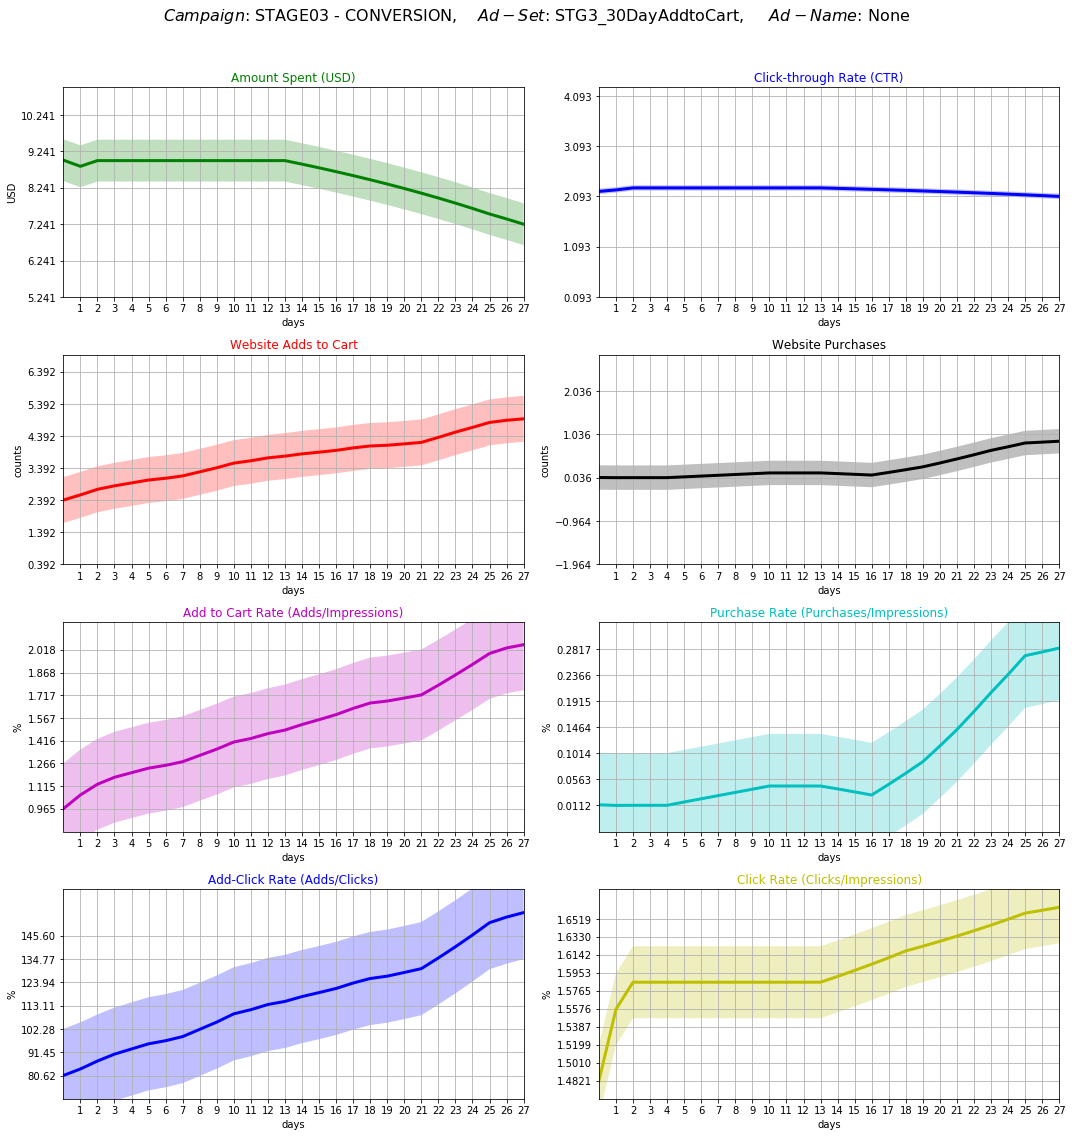

In [27]:
#Here I am making several plots in matplotlib
#Each plot contains a thick line which represents an ensemble average across the historical samples, and 
#a spread which is one standard deviation from the ensemble mean
#Each plot contains a time history of the metric, e.g.: Purchases contains on day 1 the number of purchases on day 1
#then on day 2 the sum of purchases on day1+day2 and so on.

%matplotlib inline

fig = plt.figure(figsize=(15,15))
xax = np.linspace(0,27,28)

sig  =amt.mean().std()
avg  =amt.mean()
mini =amt.mean().min()
maxi =amt.mean().max()
ax2 = fig.add_subplot(421)
ax2.plot(xax, avg, 'g-',linewidth=3.0)
ax2.fill_between(xax, avg+sig, avg-sig, facecolor='g', alpha=0.25)
ax2.set_xticks(np.arange(1, 29, 1))
ax2.set_yticks(np.arange(mini-2.0, maxi+2.0, 1))
plt.grid(True)
plt.axis([0, 27, mini-2.0, maxi+2.0])
ax2.set_title('Amount Spent (USD)',color='g')
plt.xlabel('days')
plt.ylabel('USD')


sig  =ctr.mean().std()
avg  =ctr.mean()
mini =ctr.mean().min()
maxi =ctr.mean().max()
ax3 = fig.add_subplot(422)
ax3.plot(xax, avg, 'b-',linewidth=3.0)
ax3.fill_between(xax, avg+sig, avg-sig, facecolor='b', alpha=0.25)
ax3.set_xticks(np.arange(1, 29, 1))
ax3.set_yticks(np.arange(mini-2.0, maxi+2.0, 1))
plt.grid(True)
plt.axis([0, 27, mini-2.0, maxi+2.0])
ax3.set_title('Click-through Rate (CTR)',color='b')
plt.xlabel('days')
plt.ylabel(' ')

sig  =add.mean().std()
avg  =add.mean()
mini =add.mean().min()
maxi =add.mean().max()
ax1 = fig.add_subplot(423)
ax1.plot(xax, avg, 'r-',linewidth=3.0)
ax1.fill_between(xax, avg+sig, avg-sig, facecolor='r', alpha=0.25)
ax1.set_xticks(np.arange(1, 29, 1))
ax1.set_yticks(np.arange(mini-2.0, maxi+2.0, 1))
ax1.set_title('Website Adds to Cart',color='r')
plt.xlabel('days')
plt.ylabel('counts')
plt.axis([0, 27, mini-2.0, maxi+2.0])
plt.grid(True)
plt.hold(True)

sig  =pur.mean().std()
avg  =pur.mean()
mini =pur.mean().min()
maxi =pur.mean().max()
ax4 = fig.add_subplot(424)
ax4.plot(xax, avg, 'k-',linewidth=3.0)
ax4.fill_between(xax, avg+sig, avg-sig, facecolor='k', alpha=0.25)
ax4.set_xticks(np.arange(1, 29, 1))
ax4.set_yticks(np.arange(mini-2.0, maxi+2.0, 1))
plt.grid(True)
plt.axis([0, 27, mini-2.0, maxi+2.0])
ax4.set_title('Website Purchases',color='k')
plt.xlabel('days')
plt.ylabel('counts')

atcr = (add/imp)*100.
purr = (pur/imp)*100.

sig  =atcr.mean().std()
avg  =atcr.mean()
mini =atcr.mean().min()
maxi =atcr.mean().max()
ax1 = fig.add_subplot(425)
ax1.plot(xax, avg, 'm-',linewidth=3.0)
ax1.fill_between(xax, avg+sig, avg-sig, facecolor='m', alpha=0.25)
ax1.set_xticks(np.arange(1, 29, 1))
ax1.set_yticks(np.arange(mini, maxi, (sig/2)))
ax1.set_title('Add to Cart Rate (Adds/Impressions)',color='m')
plt.xlabel('days')
plt.ylabel('%')
plt.axis([0, 27, mini-(sig/2), maxi+(sig/2)])
plt.grid(True)
plt.hold(True)

sig  =purr.mean().std()
avg  =purr.mean()
mini =purr.mean().min()
maxi =purr.mean().max()
ax1 = fig.add_subplot(426)
ax1.plot(xax, avg, 'c-',linewidth=3.0)
ax1.fill_between(xax, avg+sig, avg-sig, facecolor='c', alpha=0.25)
ax1.set_xticks(np.arange(1, 29, 1))
ax1.set_yticks(np.arange(mini, maxi, (sig/2)))
ax1.set_title('Purchase Rate (Purchases/Impressions)',color='c')
plt.xlabel('days')
plt.ylabel('%')
plt.axis([0, 27, mini-(sig/2), maxi+(sig/2)])
plt.grid(True)
plt.hold(True)

addcr = (add/cli)*100.

sig  =addcr.mean().std()
avg  =addcr.mean()
mini =addcr.mean().min()
maxi =addcr.mean().max()
ax1 = fig.add_subplot(427)
ax1.plot(xax, avg,'b-',linewidth=3.0)
ax1.fill_between(xax, avg+sig, avg-sig, facecolor='b', alpha=0.25)
ax1.set_xticks(np.arange(1, 29, 1))
ax1.set_yticks(np.arange(mini, maxi, (sig/2)))
ax1.set_title('Add-Click Rate (Adds/Clicks)',color='b')
plt.xlabel('days')
plt.ylabel('%')
plt.axis([0, 27, mini-(sig/2), maxi+(sig/2)])
plt.grid(True)
plt.hold(True)

clir = (cli/imp)*100.

sig  =clir.mean().std()
avg  =clir.mean()
mini =clir.mean().min()
maxi =clir.mean().max()
ax1 = fig.add_subplot(428)
ax1.plot(xax, avg, 'y-',linewidth=3.0)
ax1.fill_between(xax, avg+sig, avg-sig, facecolor='y', alpha=0.25)
ax1.set_xticks(np.arange(1, 29, 1))
ax1.set_yticks(np.arange(mini, maxi, (sig/2)))
ax1.set_title('Click Rate (Clicks/Impressions)',color='y')
plt.xlabel('days')
plt.ylabel('%')
plt.axis([0, 27, mini-(sig/2), maxi+(sig/2)])
plt.grid(True)
plt.hold(True)


plt.suptitle('$\it{Campaign}$: '+campa+',    $\it{Ad-Set}$: '+adset+',     $\it{Ad-Name}$: '+adnam, fontsize=16, x=0.5, y=1.05)
plt.tight_layout()

fig = plt.gcf()
plt.draw()
#plt.savefig('../flask/flaskexample/static/plot.png')
plt.show()



In [31]:
#Here I am providing some additional insights by picking the best performing ads based on user input of metric, e.g.:
#the best ads based on number of purchases
#Then I am plotting and saving a table

metric="Website Purchases" #choose the metric

ex = saved['2018-01-08'] #take the last day of all observations, here I am looking after 28 days of all observations
#not day by day

bestads =ex.nlargest(5, metric)
bestads.index=['1','2','3','4','5']
bestads.index.names = ['Rank']
bestads =bestads[["Website Purchases","Website Adds to Cart","Campaign Name","Ad Set Name","Ad Name","Impressions","Link Clicks"]]

#plt.draw()
#plt.savefig('../flask/flaskexample/static/table.png', transparent=True)

bestads


,Website Purchases,Website Adds to Cart,Campaign Name,Ad Set Name,Ad Name,Impressions,Link Clicks
Rank,,,,,,,
1,4.0,12.0,STAGE03 - CONVERSION,STG3_30DayAddtoCart,LifeHacker_B,108.0,0.0
2,1.0,14.0,STAGE03 - CONVERSION,STG3_30DayAddtoCart,LifeHacker_B,290.0,2.0
3,1.0,5.0,STAGE03 - CONVERSION,STG3_30DayAddtoCart,LifeHacker_B,98.0,2.0
4,1.0,1.0,STAGE03 - CONVERSION,STG3_30DayAddtoCart,LifeHacker_B,64.0,0.0
5,0.0,0.0,STAGE03 - CONVERSION,STG3_30DayAddtoCart,LifeHacker_B,73.0,0.0
